# Compare different z_min values for circular states

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.rydberg import RydbergState

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
qn_list = []
for n in range(15, 150):
    l = {
        "circular": n - 1,
        "intermediate": (n - 1) // 2,
        "s": 0,
        "p": 1,
        "d": 2,
    }["circular"]
    j = l + 0.5
    qn_list.append((n, l, j))

qn_list = np.array(qn_list)

In [3]:
which_turning_point = ["classical", "hydrogen", "zerocrossing"]
z_i_dict = {which: [] for which in which_turning_point}
z_i_dict["cutoff"] = []
for qn in qn_list:
    print(f"n={qn[0]}", end="\r")
    state = RydbergState("Rb", qn[0], qn[1], qn[2])
    for which in which_turning_point:
        z_i = state.model.calc_z_turning_point(which, dz=1e-3)
        z_i_dict[which].append(z_i)

    state.integrate()
    z_i_dict["cutoff"].append(state.grid.zmin)

qn_list = np.array(qn_list)

In [4]:
from arc_functions import arc_radialWavefunction

import arc

atom = arc.Rubidium87()

z_i_dict["ARC cutoff"] = []
z_i_dict["ARC_fixed cutoff"] = []
for use_fixed_arc in [False, True]:
    key = "ARC_fixed cutoff" if use_fixed_arc else "ARC cutoff"
    for qn in qn_list:
        print(f"n={qn[0]}", end="\r")
        r, psi_r = arc_radialWavefunction(atom, *qn, use_fixed_arc=use_fixed_arc)
        arg_rmin = np.argwhere(psi_r != 0).flatten()[0]
        rmin = r[arg_rmin]
        zmin = np.sqrt(rmin)
        z_i_dict[key].append(zmin)

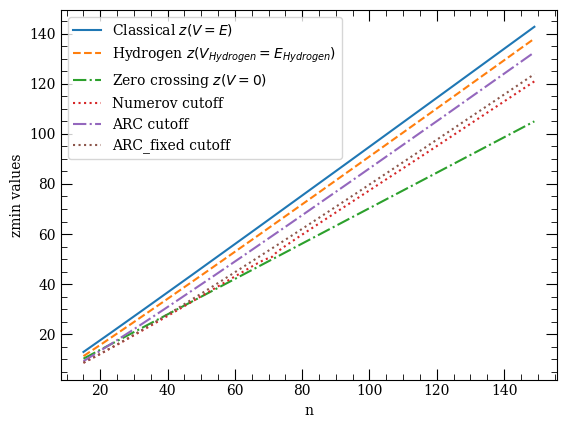

In [5]:
n_list = qn_list[:, 0]
fig, ax = plt.subplots()

labels = {
    "classical": "Classical $z(V=E)$",
    "hydrogen": r"Hydrogen $z(V_{Hydrogen}=E_{Hydrogen})$",
    "zerocrossing": r"Zero crossing $z(V=0)$",
    "cutoff": "Numerov cutoff",
}
linestyles = {
    "classical": "-",
    "hydrogen": "--",
    "zerocrossing": "-.",
    "cutoff": ":",
    "ARC cutoff": "-.",
    "ARC_fixed cutoff": ":",
}

for key, values in z_i_dict.items():
    ax.plot(n_list, values, ls=linestyles.get(key, "-"), label=labels.get(key, key))

ax.set_xlabel("n")
ax.set_ylabel("zmin values")

ax.legend()
plt.show()